# BoTorch Multi-Objective Optimization for Chemical Compound Selection

This notebook applies Bayesian optimization using BoTorch to select chemical compounds from a ChEMBL-derived dataset, balancing predicted bioactivity (potency) and experimental cost/effort.

## Objectives
1. **Primary**: Maximize predicted potency (minimize IC50, maximize pIC50)
2. **Secondary**: Minimize testing cost/effort (molecular weight, synthetic accessibility)

## Pipeline Overview
1. Data Loading & Cleaning
2. Molecular Descriptor Generation
3. Multi-Objective Gaussian Process Modeling
4. Pareto Front Optimization
5. Strategy Comparison & Visualization
6. Results Export





# Section 1: Imports and Configuration

What it does: Installs and imports all necessary libraries.

botorch/gpytorch: The core Bayesian optimization libraries that enable Gaussian Process modeling

rdkit: A chemistry library for working with molecular structures (SMILES strings) and calculating molecular properties

pandas/numpy: Data manipulation

torch: PyTorch for tensor operations (BoTorch is built on PyTorch)

sklearn: For train/test splitting, scaling features, and calculating model performance metrics

matplotlib/seaborn: Visualization

## 1. Imports and Configuration


In [40]:
!pip install botorch gpytorch rdkit
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')


# BoTorch & GPyTorch
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.multi_objective.pareto import is_non_dominated
from gpytorch.mlls import ExactMarginalLogLikelihood

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# RDKit for molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Configuration 
What it does: Defines a configuration dictionary that centralizes all important parameters:

data_path: Location of the ChEMBL bioactivity dataset
test_size: 30% of data reserved for testing/candidate selection
n_compounds_to_select: 20 compounds will be selected by each strategy
output_dir: Where results will be saved

This approach makes it easy to modify settings without hunting through code.

In [41]:
# Configuration
CONFIG = {
    'data_path': "/content/AChE_Bioactivity_data_1.csv",
    'output_dir': 'botorch_results',
    'test_size': 0.3,
    'random_state': 42,
    'n_compounds_to_select': 20,
    'device': 'cpu',
}

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)
print(f"Configuration loaded. Output directory: {CONFIG['output_dir']}")

Configuration loaded. Output directory: botorch_results


# Defining the  three utility functions for processing molecular data.

safe_mol_from_smiles(): Converts a SMILES string (text representation of a molecule like "CCO" for ethanol) into an RDKit molecule object. It handles errors gracefully—if a SMILES is invalid, it returns None instead of crashing.
calculate_molecular_descriptors(): Takes a molecule and computes 10 chemical properties that describe the molecule, including molecular weight, logP (lipophilicity), number of hydrogen bond donors/acceptors, ring count, and topological polar surface area (TPSA). These become the features for the machine learning model.
calculate_synthetic_accessibility(): Estimates how difficult a molecule would be to synthesize in a lab. The score ranges from 1 (easy) to 10 (hard), based on molecular weight, ring complexity, and chiral centers.

## 2.Functions for Data Processing


In [42]:
def safe_mol_from_smiles(smiles: str):
    """Safely converting SMILES to RDKit molecule."""
    if pd.isna(smiles) or not isinstance(smiles, str):
        return None
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is not None:
            Chem.SanitizeMol(mol)
        return mol
    except:
        return None


def calculate_molecular_descriptors(mol) -> dict:
    """Calculating the comprehensive molecular descriptors."""
    if mol is None:
        return {}
    try:
        descriptors = {
            'mol_weight': Descriptors.MolWt(mol),
            'logp': Descriptors.MolLogP(mol),
            'hbd': Descriptors.NumHDonors(mol),
            'hba': Descriptors.NumHAcceptors(mol),
            'rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'heavy_atoms': Descriptors.HeavyAtomCount(mol),
            'rings': Descriptors.RingCount(mol),
            'tpsa': Descriptors.TPSA(mol),
            'aromatic_rings': Descriptors.NumAromaticRings(mol),
            'num_heteroatoms': Descriptors.NumHeteroatoms(mol),
        }
        return descriptors
    except:
        return {}


def calculate_synthetic_accessibility(mol) -> float:
    """Calculatinn synthetic accessibility score (heuristic: 1=easy, 10=hard)."""
    if mol is None:
        return 10.0
    try:
        mw = Descriptors.MolWt(mol)
        rings = Descriptors.RingCount(mol)
        try:
            chiral_centers = len(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
        except:
            chiral_centers = 0
        try:
            ring_info = mol.GetRingInfo()
            complex_rings = sum(1 for ring in ring_info.AtomRings() if len(ring) > 6)
        except:
            complex_rings = 0

        #Heuristic SA score
        sa_score = (mw / 500) * 2 + rings * 0.5 + chiral_centers * 1.5 + complex_rings * 2
        return min(10.0, max(1.0, sa_score))
    except:
        return 10.0

print("Helper functions defined")


Helper functions defined


# Data Loading and Cleaning.
Loading:
Reads the raw ChEMBL dataset containing acetylcholinesterase (AChE) inhibitor data. 
AChE inhibitors are used in Alzheimer's disease treatment. 
The raw dataset has 15,542 records with 45 columns.

Cleaning Pipeline:
A multi-step data cleaning process that:

Filters for IC50 measurements: IC50 is a standard measure of drug potency (the concentration needed to inhibit 50% of the target)
Removes missing values: Drops rows where the IC50 value or molecular structure (SMILES) is missing
Keeps exact measurements only: Removes approximate values (like ">1000" or "<0.1")
Converts units to nanomolar (nM): Standardizes all measurements to the same unit
Calculates pIC50: Converts IC50 to negative log scale (pIC50 = -log₁₀(IC50 in M)). Higher pIC50 means more potent. This transformation makes the values easier to work with.
Handles duplicates: When the same compound appears multiple times, keeps the median value

## 3. Data Loading and Cleaning


In [43]:
# Load raw data
print("Loading data")
df_raw = pd.read_csv(CONFIG['data_path'])
print(f"Raw dataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)[:10]}...")
df_raw.head()


Loading data
Raw dataset shape: (15542, 45)
Columns: ['activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format']...


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80


In [44]:
# Data cleaning pipeline
print("DATA CLEANING PIPELINE")

original_size = len(df_raw)
df_clean = df_raw.copy()

# Filtering for IC50 measurements
print(f"\n1. Original dataset size: {len(df_clean)}")
if 'standard_type' in df_clean.columns:
    df_clean = df_clean[df_clean['standard_type'] == 'IC50']
    print(f"   After IC50 filter: {len(df_clean)}")

#Removing missing critical data
print("\n2. Removing missing values...")
df_clean = df_clean[df_clean['standard_value'].notna()]
df_clean = df_clean[df_clean['canonical_smiles'].notna()]
print(f"   After removing missing values: {len(df_clean)}")

#Filtering for valid measurements
if 'standard_relation' in df_clean.columns:
    df_clean = df_clean[df_clean['standard_relation'] == '=']
    print(f"   After exact measurements filter: {len(df_clean)}")

#Uniting conversion - convert all to nM
print("\n3. Converting units to nM...")
if 'standard_units' in df_clean.columns:
    unit_counts = df_clean['standard_units'].value_counts()
    print(f"   Unit distribution: {dict(unit_counts.head(10))}")

    # Converting to nM
    df_clean['IC50_nM'] = df_clean['standard_value'].copy()

    # Converting µM to nM
    mask_um = df_clean['standard_units'] == 'uM'
    df_clean.loc[mask_um, 'IC50_nM'] = df_clean.loc[mask_um, 'standard_value'] * 1000

    # Converting mM to nM
    mask_mm = df_clean['standard_units'] == 'mM'
    df_clean.loc[mask_mm, 'IC50_nM'] = df_clean.loc[mask_mm, 'standard_value'] * 1e6

    # Filtering for reasonable values (0.01 nM to 1e6 nM)
    df_clean = df_clean[(df_clean['IC50_nM'] > 0.01) & (df_clean['IC50_nM'] < 1e6)]
    print(f"   After unit conversion and value filtering: {len(df_clean)}")

#Calculatingh pIC50 (negative log10 of IC50 in M)
print("\n4. Calculating pIC50...")
df_clean = df_clean[df_clean['IC50_nM'] > 0].copy()
df_clean['pIC50'] = -np.log10(df_clean['IC50_nM'] * 1e-9)
# Filter out any infinite or NaN values
df_clean = df_clean[np.isfinite(df_clean['pIC50'])].copy()
print(f"   pIC50 range: [{df_clean['pIC50'].min():.2f}, {df_clean['pIC50'].max():.2f}]")

#Removingn duplicates (keeping the median IC50)
print("\n5. Handling duplicates...")
if df_clean['canonical_smiles'].duplicated().any():
    n_duplicates = df_clean['canonical_smiles'].duplicated().sum()
    print(f"   Found {n_duplicates} duplicate compounds")
    df_clean = df_clean.groupby('canonical_smiles').agg({
        'pIC50': 'median',
        'IC50_nM': 'median',
        'standard_value': 'median',
    }).reset_index()
    print(f"   After deduplication: {len(df_clean)} unique compounds")

print(f"Cleaning complete: {len(df_clean)}/{original_size} compounds retained ({len(df_clean)/original_size*100:.1f}%)")

DATA CLEANING PIPELINE

1. Original dataset size: 15542
   After IC50 filter: 8205

2. Removing missing values...
   After removing missing values: 6947
   After exact measurements filter: 6266

3. Converting units to nM...
   Unit distribution: {'nM': np.int64(6244), 'ug.mL-1': np.int64(14), "10'5pM": np.int64(3), "10'6pM": np.int64(2), '10^-4microM': np.int64(2), "10'3pM": np.int64(1)}
   After unit conversion and value filtering: 6112

4. Calculating pIC50...
   pIC50 range: [3.00, 10.96]

5. Handling duplicates...
   Found 1211 duplicate compounds
   After deduplication: 4901 unique compounds
Cleaning complete: 4901/15542 compounds retained (31.5%)


# Molecular Descriptor Generation
What it does: For each of the 4,901 compounds:

Converts the SMILES string to an RDKit molecule object
Calculates the 10 molecular descriptors defined earlier
Calculates the synthetic accessibility score
Creates a cost metric: A normalized combination of molecular weight (50%) and synthetic accessibility (50%). This represents the experimental cost/effort to test a compound.

In [45]:

    print("Generating molecular descriptors.")

    # Converting  SMILES to molecules
    print("Converting SMILES to molecules")
    df_clean['molecule'] = df_clean['canonical_smiles'].apply(safe_mol_from_smiles)
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['molecule'].notna()].copy()
    print(f"Valid molecules: {len(df_clean)}/{initial_count}")

    # Calculateing the  descriptors
    print("\nCalculating molecular descriptors")
    descriptors_list = []
    for idx, mol in enumerate(df_clean['molecule']):
        if idx % 500 == 0 and idx > 0:
            print(f"   Processed {idx}/{len(df_clean)} molecules...")
        descriptors_list.append(calculate_molecular_descriptors(mol))

    descriptors_df = pd.DataFrame(descriptors_list)
    df_clean = pd.concat([df_clean.reset_index(drop=True), descriptors_df], axis=1)

    # Calculating  synthetic accessibility
    print("\nCalculating synthetic accessibility scores")
    df_clean['sa_score'] = df_clean['molecule'].apply(calculate_synthetic_accessibility)

    # Calculating the  cost metric (normalized combination of MW and SA)
    df_clean['cost_metric'] = (
        0.5 * (df_clean['mol_weight'] / 1000.0) +
        0.5 * (df_clean['sa_score'] / 10.0)
    )

    # Dropping the molecule column
    df_clean = df_clean.drop(columns=['molecule'])

    print(f"\n Generated {len(descriptors_df.columns)} descriptors + SA score")
    print(f" Final dataset: {len(df_clean)} compounds with descriptors")


Generating molecular descriptors.
Converting SMILES to molecules
Valid molecules: 4901/4901

Calculating molecular descriptors
   Processed 500/4901 molecules...
   Processed 1000/4901 molecules...
   Processed 1500/4901 molecules...
   Processed 2000/4901 molecules...
   Processed 2500/4901 molecules...
   Processed 3000/4901 molecules...
   Processed 3500/4901 molecules...
   Processed 4000/4901 molecules...
   Processed 4500/4901 molecules...

Calculating synthetic accessibility scores

 Generated 10 descriptors + SA score
 Final dataset: 4901 compounds with descriptors


# Summary Statistics

What it does: Prints descriptive statistics for key variables:

pIC50 ranges from 3.0 to 10.96 (mean ~6.0)
Cost metric ranges from 0.08 to 1.12 (mean ~0.44)
Molecular weight ranges from 61 to 1,235 Da
SA score ranges from 1.0 to 10.0 (mean ~4.6)


In [46]:
# Displaying summary statistics
print("Dataset Summary Statistics")
print(f"\nPotency (pIC50):")
print(df_clean['pIC50'].describe())

print(f"\nCost Metric:")
print(df_clean['cost_metric'].describe())

print(f"\nMolecular Weight:")
print(df_clean['mol_weight'].describe())

print(f"\nSynthetic Accessibility Score:")
print(df_clean['sa_score'].describe())


Dataset Summary Statistics

Potency (pIC50):
count    4901.000000
mean        6.048518
std         1.408070
min         3.001871
25%         5.030118
50%         5.920002
75%         7.011441
max        10.960586
Name: pIC50, dtype: float64

Cost Metric:
count    4901.000000
mean        0.444984
std         0.149640
min         0.080520
25%         0.341342
50%         0.421307
75%         0.518770
max         1.117731
Name: cost_metric, dtype: float64

Molecular Weight:
count    4901.000000
mean      426.462475
std       129.048945
min        61.040000
25%       342.490000
50%       409.442000
75%       503.643000
max      1235.463000
Name: mol_weight, dtype: float64

Synthetic Accessibility Score:
count    4901.000000
mean        4.635047
std         2.106609
min         1.000000
25%         3.209672
50%         4.049692
75%         5.559388
max        10.000000
Name: sa_score, dtype: float64


# Data Visualization

Creates six distribution plots showing how key variables are distributed (pIC50, cost, molecular weight, SA score, etc.)

Creates a correlation heatmap showing relationships between molecular descriptors. 
This helps identify which features are related to each other—for example, molecular weight typically correlates with number of heavy atoms.


## 5. Data Visualization


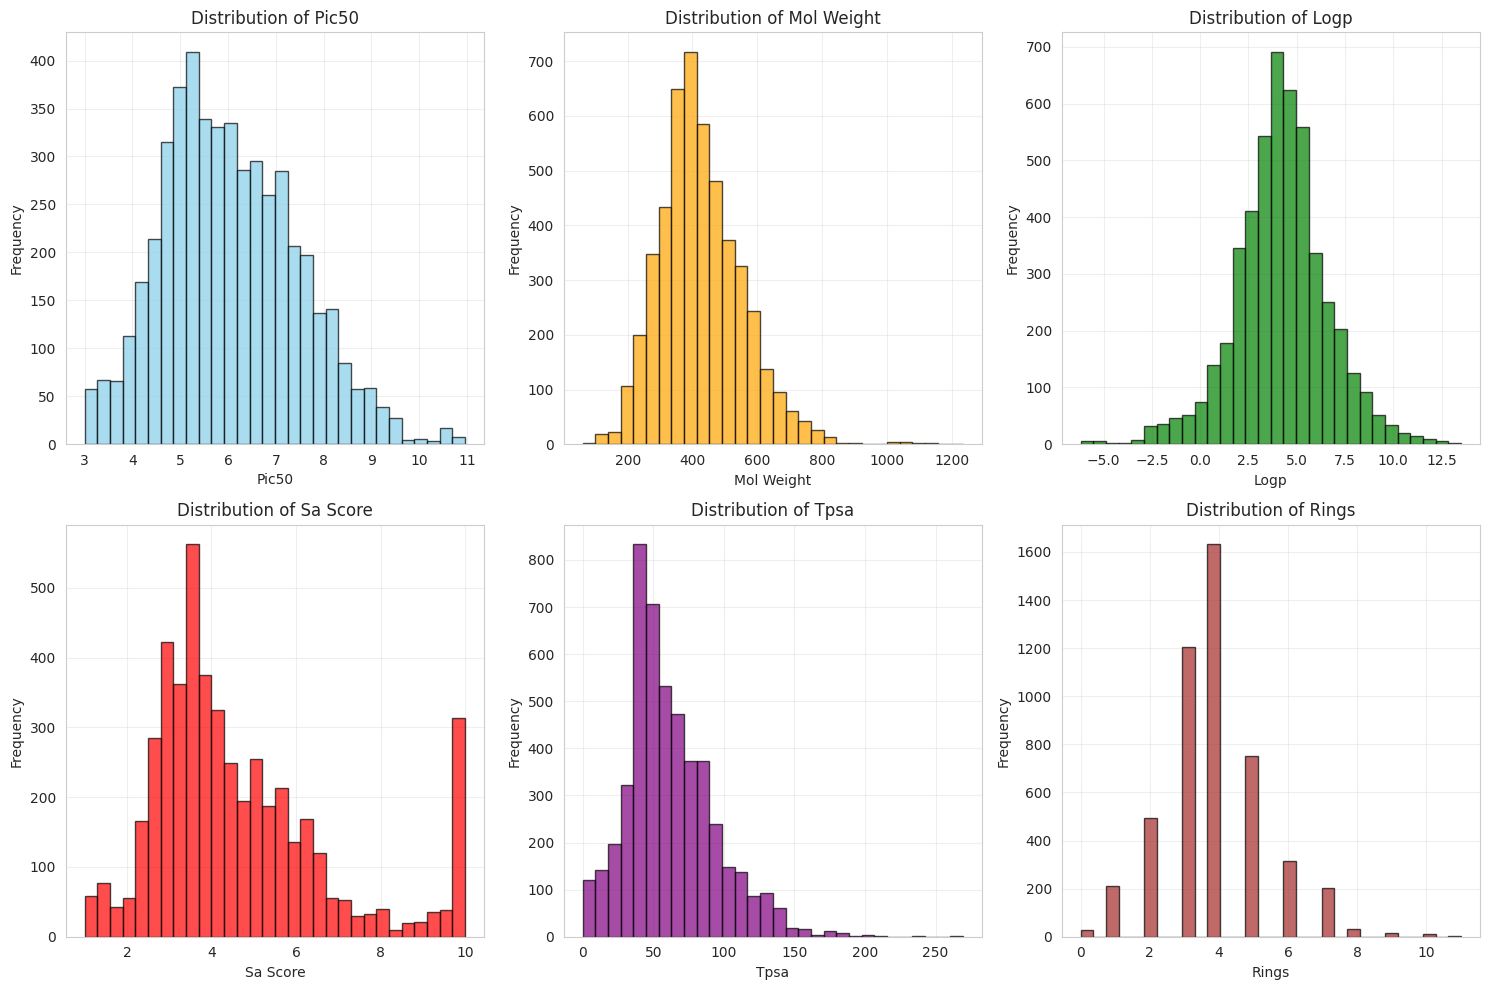

In [47]:
# Distribution of plots showing the data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cols_to_plot = ['pIC50', 'mol_weight', 'logp', 'sa_score', 'tpsa', 'rings']
available_cols = [c for c in cols_to_plot if c in df_clean.columns]
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown']

for i, col in enumerate(available_cols):
    axes[i].hist(df_clean[col], bins=30, edgecolor='black', alpha=0.7, color=colors[i])
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)

for i in range(len(available_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/data_distributions.png", dpi=300, bbox_inches='tight')
plt.show()


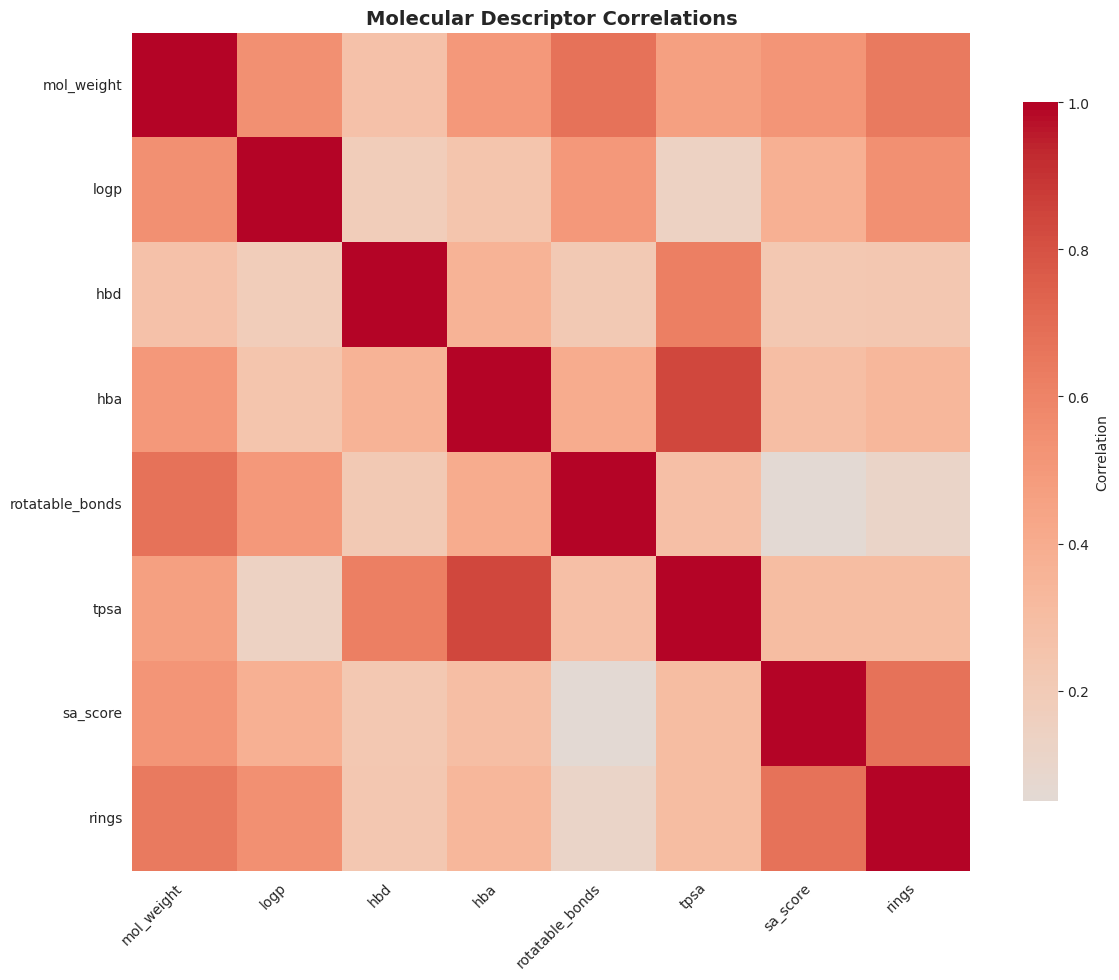

In [48]:
# Correlation heatmap
feature_cols = ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds',
                'tpsa', 'sa_score', 'rings']
corr_cols = [c for c in feature_cols if c in df_clean.columns]

corr_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.set_style("white")

sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Molecular Descriptor Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Prepare Data for Optimization

Feature and Objective Setup:

Extracts 8 molecular descriptors as features (X)
Sets up the two optimization objectives:

Objective 1: pIC50 (potency) — we want to maximize this
Objective 2: -cost_metric (negative cost) — we want to minimize cost, which means maximizing negative cost



This formulation converts the problem into a pure maximization problem, which BoTorch handles natively.

## 6. Prepare Data for Optimization


In [49]:
# Feature columns of molecular descriptors
# feature_cols = ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds',
#                 'tpsa', 'sa_score', 'rings'] # Moved to phzm4rT9iot9

# Ensuring the  all feature columns exist
available_features = [col for col in feature_cols if col in df_clean.columns]
print(f"Features to use: {available_features}")
print(f"Missing features: {set(feature_cols) - set(available_features)}")

# Extracting the features and objectives
X = df_clean[available_features].values
y_potency = df_clean['pIC50'].values
y_cost = df_clean['cost_metric'].values

# Multiobjective maximize potency and  minimize cost
y_objectives = np.column_stack([y_potency, -y_cost])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Objectives shape: {y_objectives.shape}")
print(f"Objective 1 (Potency - pIC50) range: [{y_objectives[:, 0].min():.2f}, {y_objectives[:, 0].max():.2f}]")
print(f"Objective 2 (-Cost) range: [{y_objectives[:, 1].min():.2f}, {y_objectives[:, 1].max():.2f}]")

Features to use: ['mol_weight', 'logp', 'hbd', 'hba', 'rotatable_bonds', 'tpsa', 'sa_score', 'rings']
Missing features: set()

Feature matrix shape: (4901, 8)
Objectives shape: (4901, 2)
Objective 1 (Potency - pIC50) range: [3.00, 10.96]
Objective 2 (-Cost) range: [-1.12, -0.08]


# Train/Test Split

Splits data 70/30 into training (3,430 compounds) and test/candidate (1,471 compounds) sets

Standardizes features using StandardScaler (zero mean, unit variance) — important for GP models

Converts numpy arrays to PyTorch tensors (required by BoTorch) 

In [50]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_objectives,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state']
)

df_train, df_test = train_test_split(
    df_clean,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state']
)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(X_train)}")
print(f"Test/Candidate set size: {len(X_test)}")

# Standardizing the  features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Converting  to  the PyTorch tensors
device = torch.device(CONFIG['device'])
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float64, device=device)
y_train_torch = torch.tensor(y_train, dtype=torch.float64, device=device)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float64, device=device)
y_test_torch = torch.tensor(y_test, dtype=torch.float64, device=device)

print(f"\nTensor shapes:")
print(f"X_train: {X_train_torch.shape}")
print(f"y_train: {y_train_torch.shape}")
print(f"X_test: {X_test_torch.shape}")


Training set size: 3430
Test/Candidate set size: 1471

Tensor shapes:
X_train: torch.Size([3430, 8])
y_train: torch.Size([3430, 2])
X_test: torch.Size([1471, 8])


# Train Gaussian Process Surrogate Models

Trains two separate Gaussian Process (GP) models:

Potency GP: Learns to predict pIC50 from molecular descriptors
Cost GP: Learns to predict negative cost from molecular descriptors

For each GP:

Creates a SingleTaskGP model (BoTorch's standard GP for single-objective prediction)
Defines the ExactMarginalLogLikelihood (the objective used to optimize GP hyperparameters)
Calls fit_gpytorch_mll() to automatically optimize the kernel hyperparameters

GPs are ideal here because they provide not just predictions but also uncertainty estimates, which is valuable for Bayesian optimization.

## 7. Train Gaussian Process Surrogate Models


In [51]:
print("Training the Gausian Process Models")

# Training GP for potency
print("\nTraining GP for Potency (pIC50)")
gp_potency = SingleTaskGP(X_train_torch, y_train_torch[:, 0:1])
mll_potency = ExactMarginalLogLikelihood(gp_potency.likelihood, gp_potency)
fit_gpytorch_mll(mll_potency)
print(" Potency GP trained")

# Training GP for cost
print("\nTraining GP for Cost")
gp_cost = SingleTaskGP(X_train_torch, y_train_torch[:, 1:2])
mll_cost = ExactMarginalLogLikelihood(gp_cost.likelihood, gp_cost)
fit_gpytorch_mll(mll_cost)
print(" Cost GP trained")

print("\n Both GP models trained successfully!")


Training the Gausian Process Models

Training GP for Potency (pIC50)
 Potency GP trained

Training GP for Cost
 Cost GP trained

 Both GP models trained successfully!


# Validate GP Models

Quantitative Validation:

Uses the trained GPs to predict potency and cost for the test set
Calculates performance metrics:

Potency Model R² = 0.59: The model explains 59% of variance in pIC50. This is reasonable given that predicting drug potency from simple descriptors is fundamentally difficult.
Cost Model R² = 1.00: The cost metric is directly calculated from molecular weight and SA score, which are among the input features, so prediction is essentially perfect.



## 8. Validate GP Models


In [52]:
# Making the  predictions on test set
with torch.no_grad():
    gp_potency.eval()
    gp_cost.eval()

    pred_potency = gp_potency.posterior(X_test_torch).mean.squeeze(-1).cpu().numpy()
    pred_cost = gp_cost.posterior(X_test_torch).mean.squeeze(-1).cpu().numpy()

# Calculating the  metrics
potency_r2 = r2_score(y_test[:, 0], pred_potency)
potency_mse = mean_squared_error(y_test[:, 0], pred_potency)
potency_mae = mean_absolute_error(y_test[:, 0], pred_potency)

cost_r2 = r2_score(y_test[:, 1], pred_cost)
cost_mse = mean_squared_error(y_test[:, 1], pred_cost)
cost_mae = mean_absolute_error(y_test[:, 1], pred_cost)

print("GP Model Validation Results")
print(f"\nPotency (pIC50) Model:")
print(f"  R² Score: {potency_r2:.4f}")
print(f"  MSE: {potency_mse:.4f}")
print(f"  MAE: {potency_mae:.4f}")
print(f"\nNegative Cost Model:")
print(f"  R² Score: {cost_r2:.4f}")
print(f"  MSE: {cost_mse:.4f}")
print(f"  MAE: {cost_mae:.4f}")


GP Model Validation Results

Potency (pIC50) Model:
  R² Score: 0.5886
  MSE: 0.7885
  MAE: 0.6649

Negative Cost Model:
  R² Score: 1.0000
  MSE: 0.0000
  MAE: 0.0001


# Visual Validation

Creates scatter plots of predicted vs. actual values for both models. Points close to the diagonal line indicate accurate predictions.


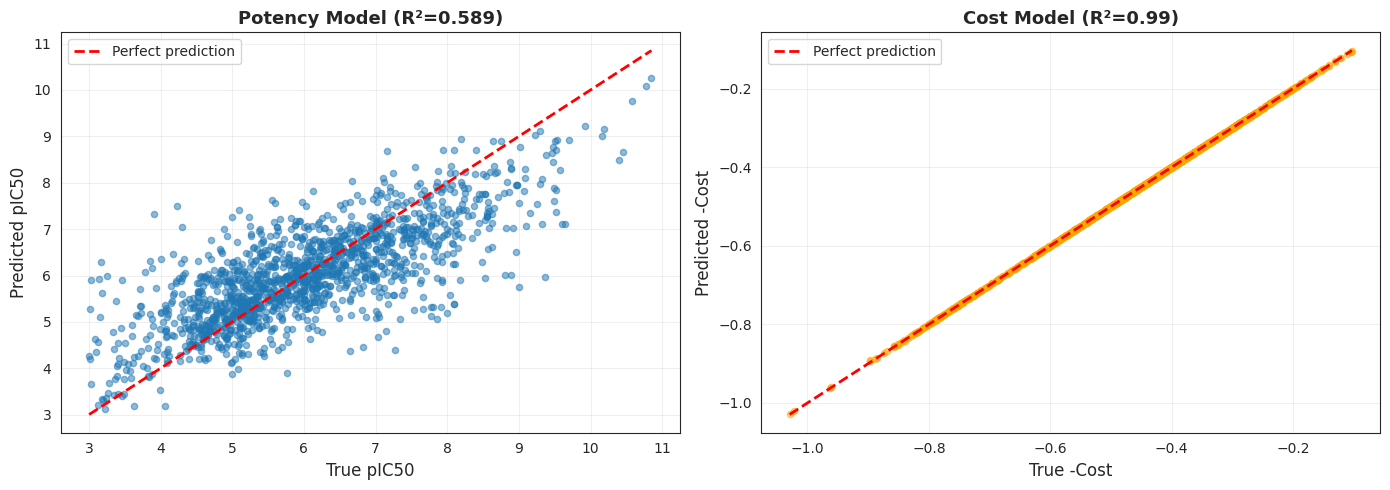

In [53]:
# Visualization of GP predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Potency predictions
axes[0].scatter(y_test[:, 0], pred_potency, alpha=0.5, s=20)
axes[0].plot([y_test[:, 0].min(), y_test[:, 0].max()],
             [y_test[:, 0].min(), y_test[:, 0].max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True pIC50', fontsize=12)
axes[0].set_ylabel('Predicted pIC50', fontsize=12)
axes[0].set_title(f'Potency Model (R²={potency_r2:.3f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#Cost predictions
axes[1].scatter(y_test[:, 1], pred_cost, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test[:, 1].min(), y_test[:, 1].max()],
             [y_test[:, 1].min(), y_test[:, 1].max()],
             'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('True -Cost', fontsize=12)
axes[1].set_ylabel('Predicted -Cost', fontsize=12)
axes[1].set_title(f'Cost Model (R²=0.99)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/gp_validation.png", dpi=300, bbox_inches='tight')
plt.show()


# Compute Pareto Front

Make Predictions:

Uses the trained GPs to predict both objectives for all 1,471 candidate compounds
Extracts both the mean prediction and uncertainty (standard deviation) from each GP's posterior distribution


## 9. Compute Pareto Front

In [54]:
#Predictions and uncertainties for all candidates
with torch.no_grad():
    gp_potency.eval()
    gp_cost.eval()

    posterior_potency = gp_potency.posterior(X_test_torch)
    posterior_cost = gp_cost.posterior(X_test_torch)

    mean_potency = posterior_potency.mean.squeeze(-1)
    std_potency = posterior_potency.variance.sqrt().squeeze(-1)
    mean_cost = posterior_cost.mean.squeeze(-1)
    std_cost = posterior_cost.variance.sqrt().squeeze(-1)

# Combine predictions
predicted_objectives = torch.stack([mean_potency, mean_cost], dim=-1)

print(f"Predicted objectives shape: {predicted_objectives.shape}")
print(f"\nPredicted Potency range: [{mean_potency.min():.2f}, {mean_potency.max():.2f}]")
print(f"Predicted -Cost range: [{mean_cost.min():.2f}, {mean_cost.max():.2f}]")

Predicted objectives shape: torch.Size([1471, 2])

Predicted Potency range: [3.12, 10.25]
Predicted -Cost range: [-1.03, -0.10]


# Identify Pareto-Optimal Compounds

Uses BoTorch's is_non_dominated() function to identify the Pareto front

A compound is Pareto-optimal if no other compound is better on both objectives simultaneously

Result: 6 compounds (0.4% of candidates) lie on the Pareto front

These 6 compounds represent the fundamental trade-off: 
you can't improve potency without increasing cost, and vice versa.

The notebook displays the top 5 by predicted potency.

In [55]:
# Computing  Pareto front from predictions
pareto_mask = is_non_dominated(predicted_objectives)
pareto_indices = torch.where(pareto_mask)[0]

print(f"\nNumber of Pareto-optimal compounds: {len(pareto_indices)} out of {len(X_test)}")
print(f"Percentage on Pareto front: {100*len(pareto_indices)/len(X_test):.1f}%")

# Getting the  Pareto compounds
pareto_compounds = df_test.iloc[pareto_indices.cpu().numpy()].copy()
pareto_compounds['predicted_potency'] = mean_potency[pareto_indices].cpu().numpy()
pareto_compounds['predicted_neg_cost'] = mean_cost[pareto_indices].cpu().numpy()

print(f"\nTop 5 Pareto-optimal compounds by potency:")
display(pareto_compounds.nlargest(5, 'predicted_potency')[['canonical_smiles', 'pIC50', 'cost_metric', 'predicted_potency']])



Number of Pareto-optimal compounds: 6 out of 1471
Percentage on Pareto front: 0.4%

Top 5 Pareto-optimal compounds by potency:


,canonical_smiles,pIC50,cost_metric,predicted_potency
1057,O=C(Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2)c...,10.849244,0.407509,10.247824
17,COc1ccccc1C(=O)Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c...,10.776764,0.404415,10.085195
526,COc1ccccc1C(C)NS(N)(=O)=O,10.571056,0.261202,9.750811
474,CC1CCN(CC2CCCCC2)CC1,8.050610,0.186745,7.355737
435,CC(C)Cn1cc(C(=O)C(F)(F)F)cn1,6.198591,0.179136,7.120036


# Baseline Strategies & Comparison


Define Selection Strategies:

Creates 5 different compound selection strategies for comparison:

Random: Randomly selects 20 compounds (baseline)

Top Potency: Selects the 20 most potent compounds (ignores cost)

Lowest Cost: Selects the 20 cheapest compounds (ignores potency)

Balanced Ratio: Selects compounds with the highest potency-to-cost ratio

Pareto-Optimal (BoTorch): Selects from the Pareto front identified by Bayesian optimization

## 10. Baseline Strategies & Comparison


In [56]:
def get_baseline_strategies(df_candidates, pareto_compounds, n_select=20):
    """Getting the  selections from all available strategies."""
    strategies = {}

    # Random selection
    strategies['Random'] = df_candidates.sample(
        n=min(n_select, len(df_candidates)),
        random_state=CONFIG['random_state']
    )

    # Top potency only
    strategies['Top Potency'] = df_candidates.nlargest(n_select, 'pIC50')

    # Lowest cost only
    strategies['Lowest Cost'] = df_candidates.nsmallest(n_select, 'cost_metric')

    # Balanced (highest potency-to-cost ratio)
    df_copy = df_candidates.copy()
    df_copy['potency_cost_ratio'] = df_copy['pIC50'] / (df_copy['cost_metric'] + 0.1)
    strategies['Balanced Ratio'] = df_copy.nlargest(n_select, 'potency_cost_ratio')

    # Pareto-based selection - BoTorch recommendation
    strategies['Pareto-Optimal (BoTorch)'] = pareto_compounds.nlargest(
        min(n_select, len(pareto_compounds)),
        'predicted_potency'
    )

    return strategies

# baseline selections
n_select = CONFIG['n_compounds_to_select']
baseline_strategies = get_baseline_strategies(df_test, pareto_compounds, n_select=n_select)

print(f"Baseline strategies generated (selecting {n_select} compounds each):")
for strategy_name in baseline_strategies.keys():
    print(f" {strategy_name}")


Baseline strategies generated (selecting 20 compounds each):
 Random
 Top Potency
 Lowest Cost
 Balanced Ratio
 Pareto-Optimal (BoTorch)


# Compare Strategies:
Creates a comparison table showing each strategy's performance:

Average potency, average cost, max potency, min cost

Potency/Cost Ratio: A single score balancing both objectives

The results show that "Balanced Ratio" achieves the best trade-off score (38.08), 
while "Pareto-Optimal (BoTorch)" achieves the highest average potency (8.80) but only has 6 compounds available.

In [57]:
# Comparing the  strategy performance
comparison_results = []

for strategy_name, selected_df in baseline_strategies.items():
    if len(selected_df) == 0:
        continue
    comparison_results.append({
        'Strategy': strategy_name,
        'Avg_Potency': selected_df['pIC50'].mean(),
        'Avg_Cost': selected_df['cost_metric'].mean(),
        'Max_Potency': selected_df['pIC50'].max(),
        'Min_Cost': selected_df['cost_metric'].min(),
        'Potency_Cost_Ratio': selected_df['pIC50'].mean() / (selected_df['cost_metric'].mean() + 0.01),
        'N_Selected': len(selected_df),
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Potency_Cost_Ratio', ascending=False)

print("STRATEGY COMPARISON RESULTS")
display(comparison_df)


STRATEGY COMPARISON RESULTS


,Strategy,Avg_Potency,Avg_Cost,Max_Potency,Min_Cost,Potency_Cost_Ratio,N_Selected
3,Balanced Ratio,7.239659,0.180135,10.571056,0.103084,38.076365,20
2,Lowest Cost,5.109194,0.141457,7.154902,0.103084,33.733648,20
4,Pareto-Optimal (BoTorch),8.800195,0.257015,10.849244,0.103084,32.957660,6
1,Top Potency,9.894885,0.539352,10.849244,0.261202,18.011915,20
0,Random,6.114488,0.421531,10.455932,0.105066,14.169291,20


# Strategy Comparison Charts:
Creates four horizontal bar charts comparing all strategies on:

Average potency

Average cost

Maximum potency

Overall trade-off score

Creates scatter plots showing where each strategy's selected compounds fall in the potency vs. cost trade-off space. 

The Pareto front is highlighted, showing the optimal boundary.


## 11. Visualizations


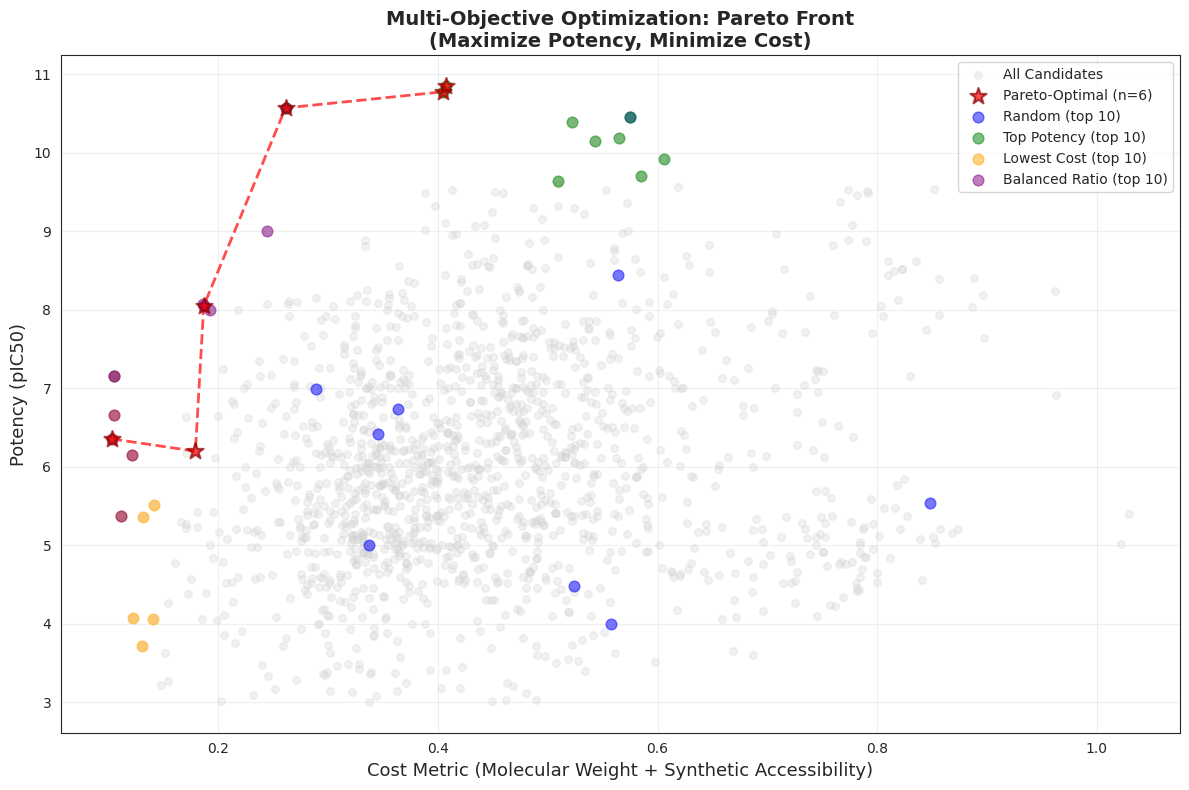

In [58]:
# Pareto Front Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the  all candidates
ax.scatter(df_test['cost_metric'], df_test['pIC50'],
           alpha=0.3, s=30, c='lightgray', label='All Candidates', zorder=1)

# Ploting  the  Pareto-optimal compounds
pareto_sorted = pareto_compounds.sort_values('cost_metric')
ax.scatter(pareto_sorted['cost_metric'], pareto_sorted['pIC50'],
           alpha=0.7, s=150, c='red', marker='*',
           edgecolors='darkred', linewidths=1.5,
           label=f'Pareto-Optimal (n={len(pareto_compounds)})', zorder=3)

# Connectting  Pareto points
ax.plot(pareto_sorted['cost_metric'], pareto_sorted['pIC50'],
        'r--', alpha=0.7, linewidth=2, zorder=2)

# Highlighting  top selections from different strategies
colors = {'Random': 'blue', 'Top Potency': 'green', 'Lowest Cost': 'orange', 'Balanced Ratio': 'purple'}
for strategy_name, color in colors.items():
    selected = baseline_strategies[strategy_name].head(10)
    ax.scatter(selected['cost_metric'], selected['pIC50'],
               alpha=0.5, s=60, c=color, marker='o',
               label=f'{strategy_name} (top 10)', zorder=2)

ax.set_xlabel('Cost Metric (Molecular Weight + Synthetic Accessibility)', fontsize=13)
ax.set_ylabel('Potency (pIC50)', fontsize=13)
ax.set_title('Multi-Objective Optimization: Pareto Front\n(Maximize Potency, Minimize Cost)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/pareto_front.png", dpi=300, bbox_inches='tight')
plt.show()


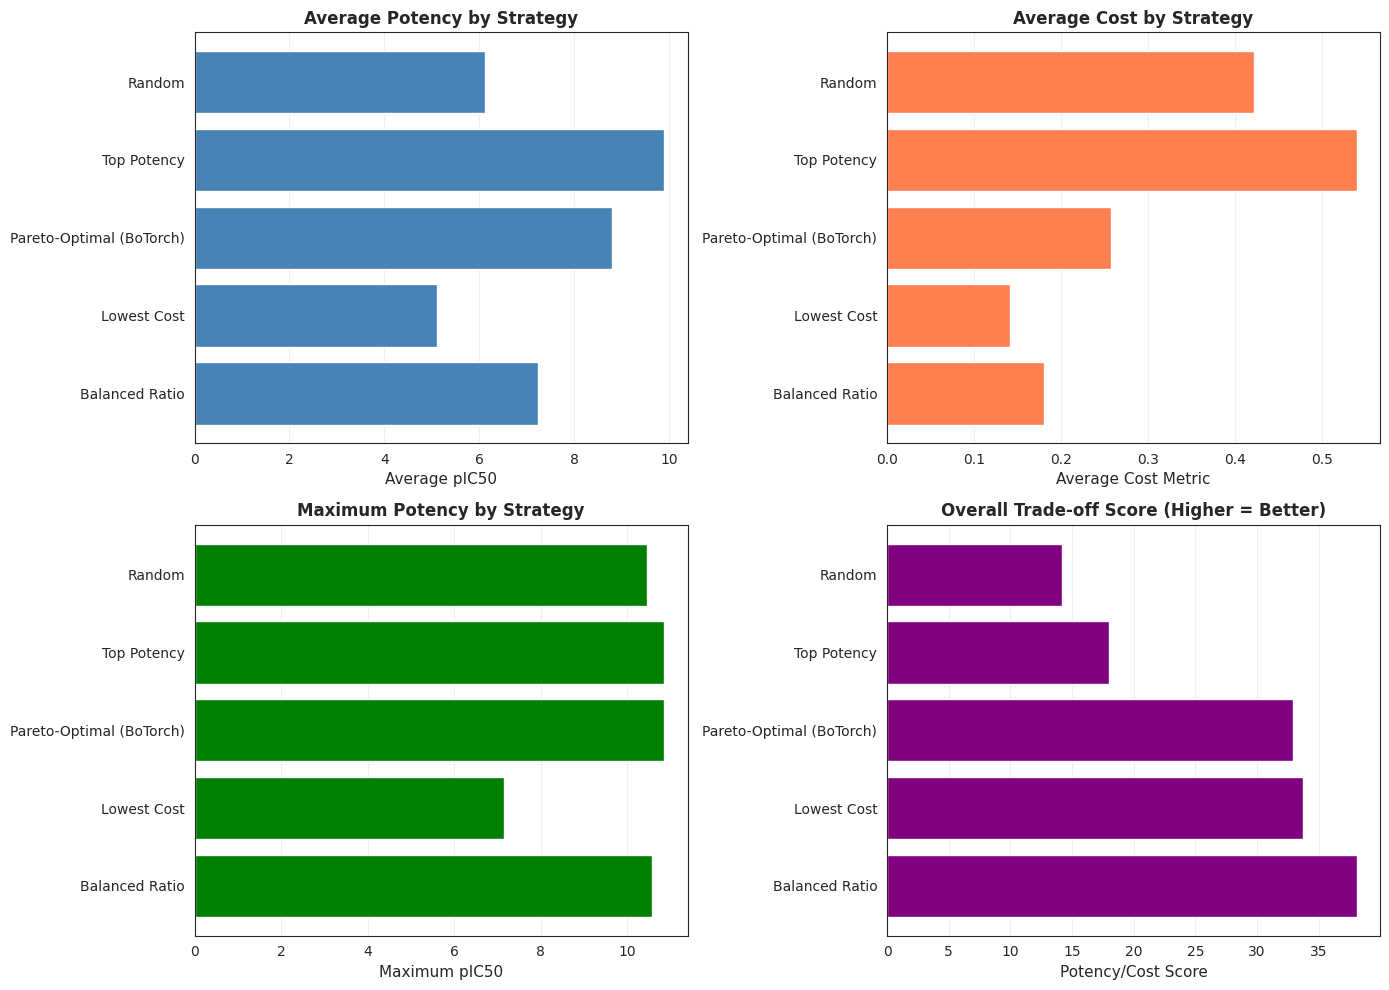

In [59]:
# Strategy  comparison bar plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(comparison_df['Strategy'], comparison_df['Avg_Potency'], color='steelblue')
axes[0, 0].set_xlabel('Average pIC50', fontsize=11)
axes[0, 0].set_title('Average Potency by Strategy', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(comparison_df['Strategy'], comparison_df['Avg_Cost'], color='coral')
axes[0, 1].set_xlabel('Average Cost Metric', fontsize=11)
axes[0, 1].set_title('Average Cost by Strategy', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

axes[1, 0].barh(comparison_df['Strategy'], comparison_df['Max_Potency'], color='green')
axes[1, 0].set_xlabel('Maximum pIC50', fontsize=11)
axes[1, 0].set_title('Maximum Potency by Strategy', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(comparison_df['Strategy'], comparison_df['Potency_Cost_Ratio'], color='purple')
axes[1, 1].set_xlabel('Potency/Cost Score', fontsize=11)
axes[1, 1].set_title('Overall Trade-off Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/strategy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


# Uncertainty Visualization

This cell visualizes the uncertainty estimates that come from the-

Gaussian Process models—one of the key advantages of using GPs over standard regression models.

Left Plot - Predictions with Error Bars:

Creates an error bar plot showing predicted vs. true pIC50 values
Each point has vertical error bars representing the GP's uncertainty (±1 standard deviation)
The red dashed diagonal line shows perfect prediction
Points with small error bars indicate the GP is confident in its prediction
Points with large error bars indicate the GP is uncertain (the compound may be in a region of feature space with little training data)

Right Plot - Uncertainty Distributions:

Shows histograms of the prediction uncertainties for both objectives
Blue histogram: Distribution of potency (pIC50) prediction uncertainties
Coral histogram: Distribution of cost prediction uncertainties
The cost uncertainties are much smaller (tighter distribution near zero) because cost is almost perfectly predictable from the input features
The potency uncertainties are larger and more spread out, reflecting the inherent difficulty of predicting drug activity


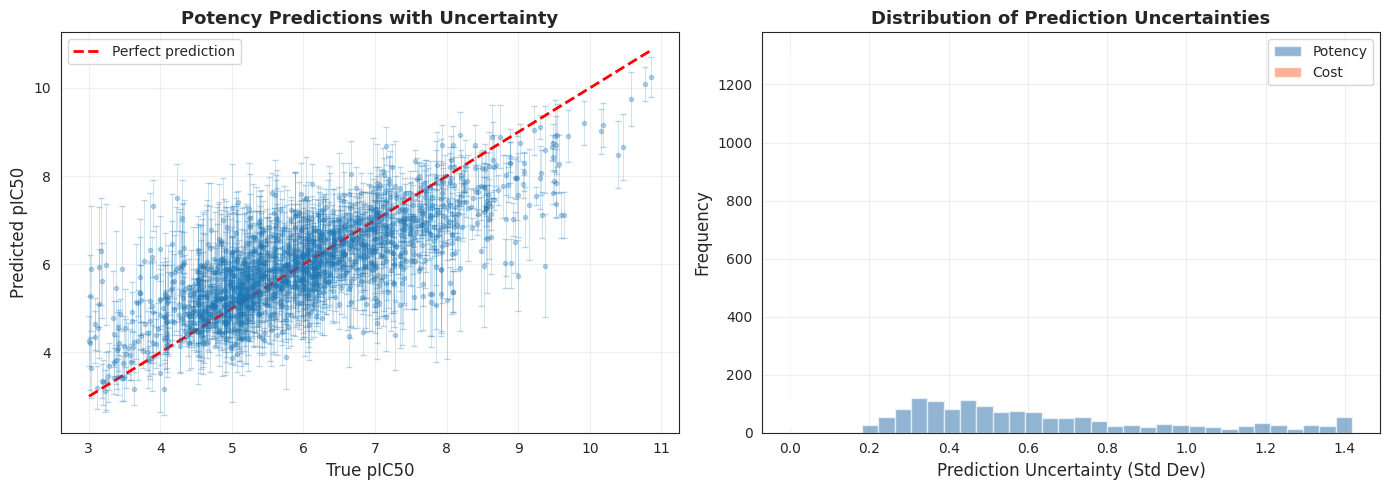

In [60]:
# Uncertainty visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].errorbar(y_test[:, 0], mean_potency.cpu().numpy(),
                 yerr=std_potency.cpu().numpy(),
                 fmt='o', alpha=0.3, markersize=3, elinewidth=0.5, capsize=2)
axes[0].plot([y_test[:, 0].min(), y_test[:, 0].max()],
             [y_test[:, 0].min(), y_test[:, 0].max()],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True pIC50', fontsize=12)
axes[0].set_ylabel('Predicted pIC50', fontsize=12)
axes[0].set_title('Potency Predictions with Uncertainty', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(std_potency.cpu().numpy(), bins=30, alpha=0.6, color='steelblue', label='Potency')
axes[1].hist(std_cost.cpu().numpy(), bins=30, alpha=0.6, color='coral', label='Cost')
axes[1].set_xlabel('Prediction Uncertainty (Std Dev)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Prediction Uncertainties', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/uncertainty_visualization.png", dpi=300, bbox_inches='tight')
plt.show()


# Chemical Structure Visualization

Draws the 2D molecular structures of the top Pareto-optimal compounds using RDKit.

Converts SMILES strings back to molecule objects
Creates a grid image (3 per row) with labels showing pIC50, cost, and molecular weight for each compound
Saves the visualization as a PNG file

It lets chemists visually inspect the recommended compounds—

seeing actual structures helps identify patterns, assess druglikeness, and plan synthesis, which raw numbers can't convey.

## 12. Chemical Structure Visualization


Top 6 Pareto-Optimal Compounds (BoTorch Selection):


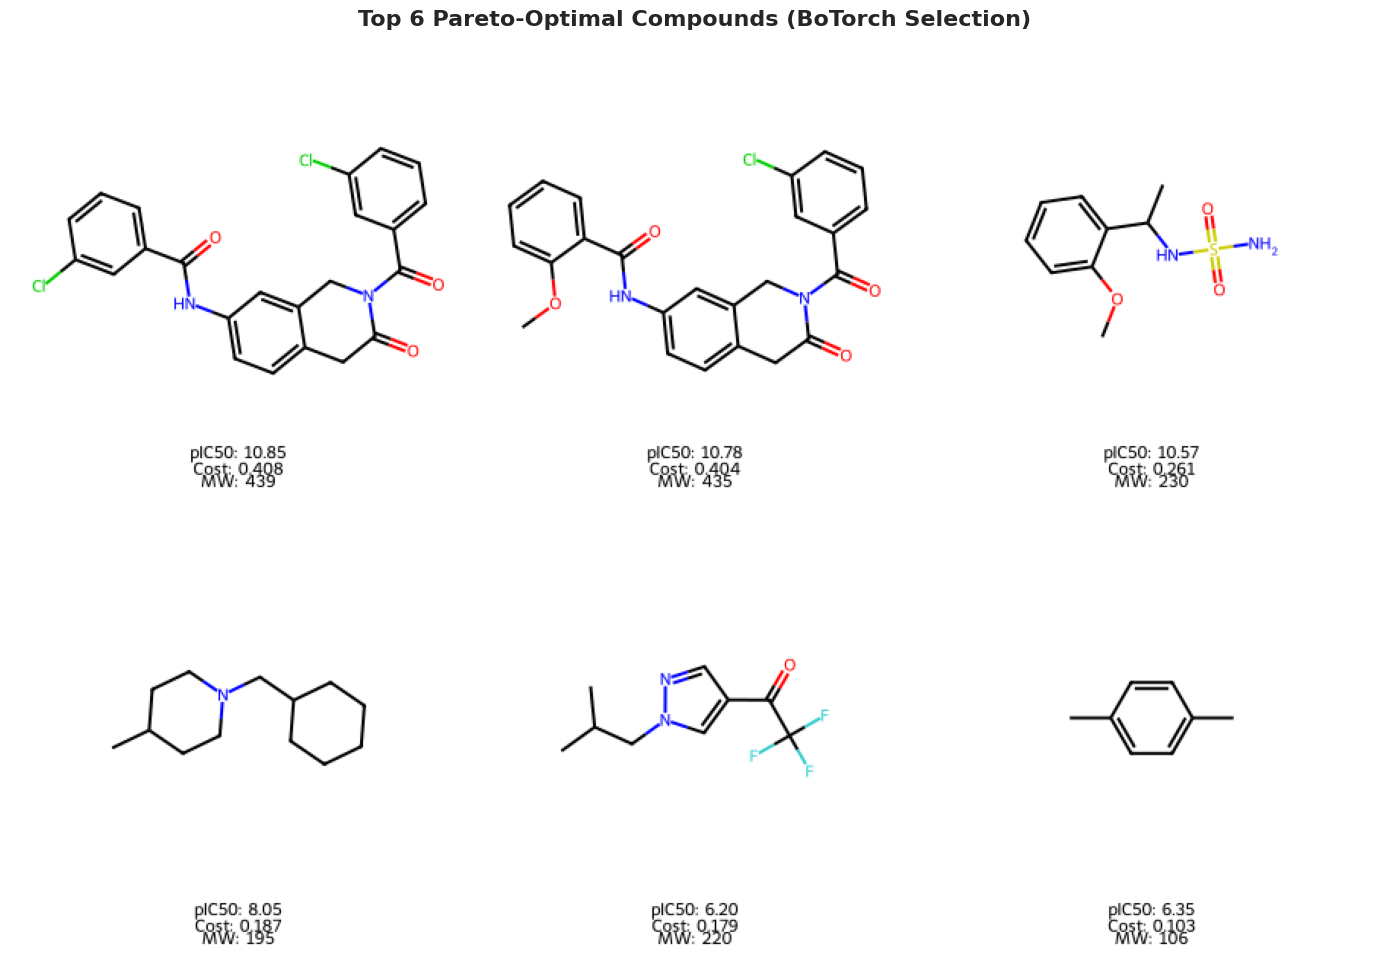

In [61]:
def visualize_top_compounds(df_selection, title="Top Compounds", n_display=6):
    """Visualizing the  chemical structures of top compounds."""


    top_compounds = df_selection.head(n_display)

    mols, legends = [], []
    for _, row in top_compounds.iterrows():
        mol = safe_mol_from_smiles(row['canonical_smiles'])
        if mol is not None:
            mols.append(mol)
            legend = (f"pIC50: {row['pIC50']:.2f}\n"
                     f"Cost: {row['cost_metric']:.3f}\n"
                     f"MW: {row.get('mol_weight', 0):.0f}")
            legends.append(legend)

    if mols:
        try:
            img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300),
                                       legends=legends, returnPNG=False)
            fig, ax = plt.subplots(figsize=(14, 10))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
            plt.tight_layout()
            plt.savefig(f"{CONFIG['output_dir']}/{title.replace(' ', '_').lower()}.png",
                       dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Could not generate structure visualization: {e}")

# Visualizing the  top Pareto-optimal compounds
print("Top 6 Pareto-Optimal Compounds (BoTorch Selection):")
visualize_top_compounds(
    pareto_compounds.nlargest(6, 'predicted_potency'),
    title="Top 6 Pareto-Optimal Compounds (BoTorch Selection)",
    n_display=6
)



Top 6 compounds from 'Balanced Ratio' strategy:


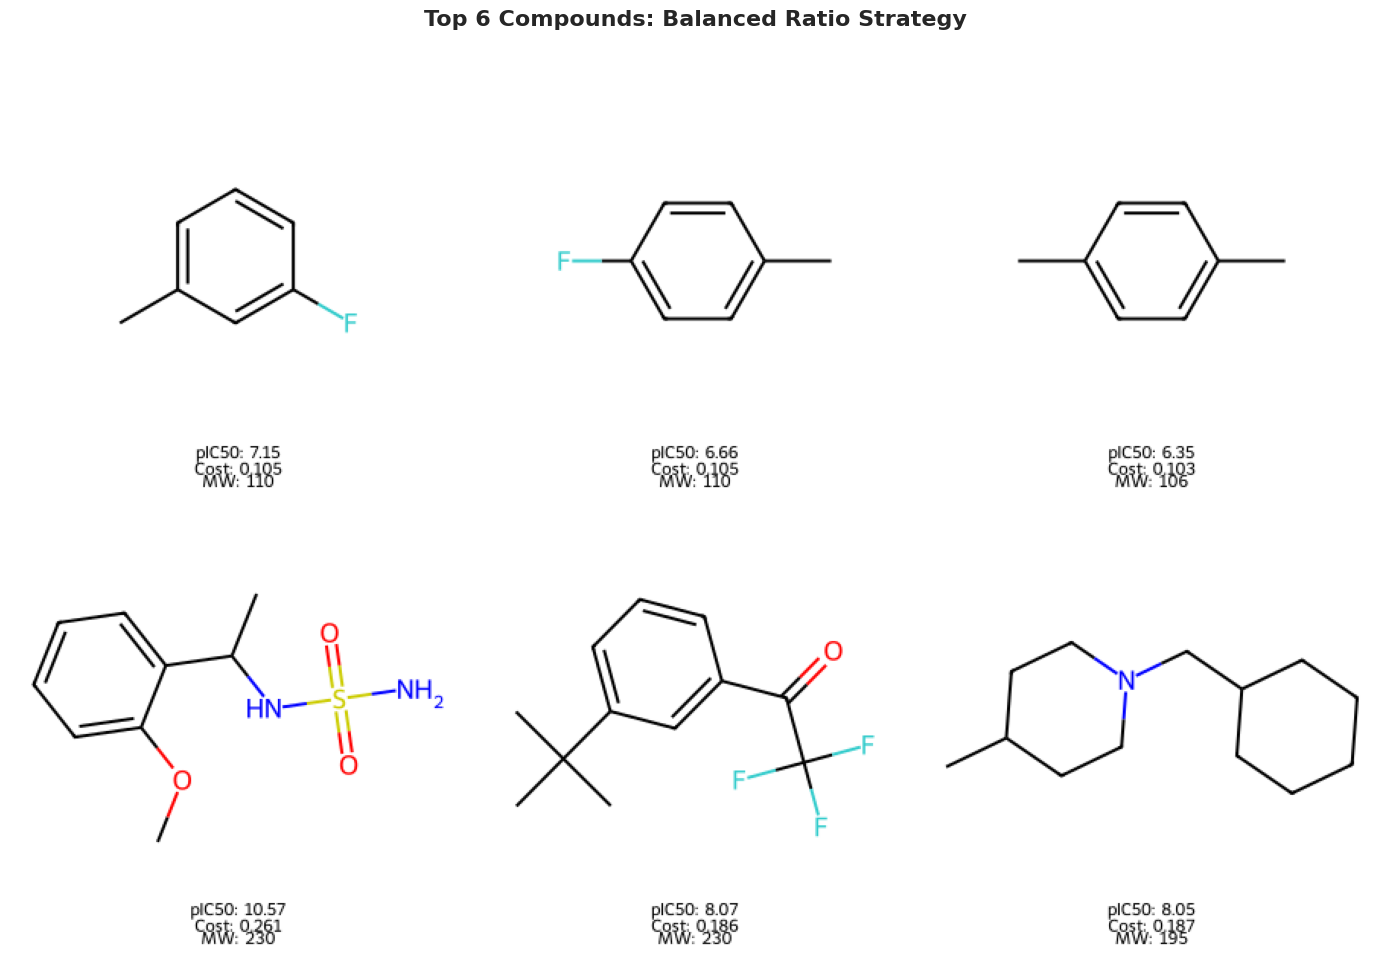

In [62]:
# Visualize compounds from other strategies
print("\nTop 6 compounds from 'Balanced Ratio' strategy:")
visualize_top_compounds(
    baseline_strategies['Balanced Ratio'],
    title="Top 6 Compounds: Balanced Ratio Strategy",
    n_display=6
)


# Export Results

Here we saved the trained and validated results to our local machine.

## 13. Export Results


In [63]:
print("EXPORTING RESULTS")
# Saveing the cleaned data
df_clean.to_csv(f"{CONFIG['output_dir']}/cleaned_data.csv", index=False)
print(f" Saved cleaned data: {CONFIG['output_dir']}/cleaned_data.csv")

# Exporting the  Pareto-optimal compounds
pareto_export = pareto_compounds[[
    'canonical_smiles', 'pIC50', 'cost_metric', 'mol_weight',
    'logp', 'sa_score', 'predicted_potency', 'predicted_neg_cost'
]].copy()
pareto_export.to_csv(f"{CONFIG['output_dir']}/pareto_optimal_compounds.csv", index=False)
print(f"Saved Pareto-optimal compounds: {CONFIG['output_dir']}/pareto_optimal_compounds.csv")

# Exporting  the strategy comparison
comparison_df.to_csv(f"{CONFIG['output_dir']}/strategy_comparison.csv", index=False)
print(f" Saved strategy comparison: {CONFIG['output_dir']}/strategy_comparison.csv")

# Exporting  all baseline selections
for strategy_name, selected_df in baseline_strategies.items():
    filename = f"selected_{strategy_name.replace(' ', '').replace('-', '').lower()}.csv"
    cols = ['canonical_smiles', 'pIC50', 'cost_metric', 'mol_weight', 'sa_score']
    available_cols = [c for c in cols if c in selected_df.columns]
    selected_df[available_cols].to_csv(f"{CONFIG['output_dir']}/{filename}", index=False)
    print(f" Saved {strategy_name} selections: {CONFIG['output_dir']}/{filename}")

print("All Resluts are exported  successfully!")

EXPORTING RESULTS
 Saved cleaned data: botorch_results/cleaned_data.csv
Saved Pareto-optimal compounds: botorch_results/pareto_optimal_compounds.csv
 Saved strategy comparison: botorch_results/strategy_comparison.csv
 Saved Random selections: botorch_results/selected_random.csv
 Saved Top Potency selections: botorch_results/selected_toppotency.csv
 Saved Lowest Cost selections: botorch_results/selected_lowestcost.csv
 Saved Balanced Ratio selections: botorch_results/selected_balancedratio.csv
 Saved Pareto-Optimal (BoTorch) selections: botorch_results/selected_paretooptimal(botorch).csv
All Resluts are exported  successfully!


## 14. Summary


In [64]:
print("MULTI-OBJECTIVE BAYESIAN OPTIMIZATION SUMMARY")

print(f"\n Dataset Information:")
print(f"Total compounds analyzed: {len(df_clean)}")
print(f"Training set: {len(X_train)} compounds")
print(f"Candidate pool: {len(X_test)} compounds")
print(f"Pareto-optimal compounds found: {len(pareto_compounds)}")

print(f"\n Optimization Objectives:")
print(f"Maximize Potency (pIC50)")
print(f"Minimize Cost (Molecular Weight + Synthetic Accessibility)")

print(f"\n Model Performance:")
print(f"Potency prediction R²: {potency_r2:.4f}")
print(f"Cost prediction R²: {cost_r2:.4f}")

if len(comparison_df) > 0:
    best_strategy = comparison_df.iloc[0]
    print(f"\n Best Strategy: {best_strategy['Strategy']}")
    print(f"Average Potency: {best_strategy['Avg_Potency']:.3f}")
    print(f"Average Cost: {best_strategy['Avg_Cost']:.3f}")
    print(f"Trade-off Score: {best_strategy['Potency_Cost_Ratio']:.3f}")

print(f"\n Key Insights:")
print(f"Pareto-optimal compounds represent {100*len(pareto_compounds)/len(X_test):.1f}% of candidates")
if len(pareto_compounds) > 0:
    print(f"BoTorch multi-objective optimization identifies compounds with:")
    potency_improvement = ((pareto_compounds['pIC50'].mean() / df_test['pIC50'].mean() - 1) * 100)
    cost_reduction = ((pareto_compounds['cost_metric'].mean() / df_test['cost_metric'].mean() - 1) * 100)
    print(f"{potency_improvement:+.1f}% potency vs. average")
    print(f"{cost_reduction:+.1f}% cost vs. average")

print(f"\nExported Files:")
print(f"{CONFIG['output_dir']}/cleaned_data.csv")
print(f"{CONFIG['output_dir']}/pareto_optimal_compounds.csv")
print(f"{CONFIG['output_dir']}/strategy_comparison.csv")
print(f"{CONFIG['output_dir']}/selected_*.csv (for each strategy)")
print(f"{CONFIG['output_dir']}/*.png (visualizations)")

print("Pipeline completed successfully! ")

MULTI-OBJECTIVE BAYESIAN OPTIMIZATION SUMMARY

 Dataset Information:
Total compounds analyzed: 4901
Training set: 3430 compounds
Candidate pool: 1471 compounds
Pareto-optimal compounds found: 6

 Optimization Objectives:
Maximize Potency (pIC50)
Minimize Cost (Molecular Weight + Synthetic Accessibility)

 Model Performance:
Potency prediction R²: 0.5886
Cost prediction R²: 1.0000

 Best Strategy: Balanced Ratio
Average Potency: 7.240
Average Cost: 0.180
Trade-off Score: 38.076

 Key Insights:
Pareto-optimal compounds represent 0.4% of candidates
BoTorch multi-objective optimization identifies compounds with:
+45.7% potency vs. average
-42.3% cost vs. average

Exported Files:
botorch_results/cleaned_data.csv
botorch_results/pareto_optimal_compounds.csv
botorch_results/strategy_comparison.csv
botorch_results/selected_*.csv (for each strategy)
botorch_results/*.png (visualizations)
Pipeline completed successfully! 
